In [1]:
import pandas as pd

# Load data
data = pd.read_csv("../new_csv/data_with_agents_split.csv")
data.head()

,GameRulesetName,Id,agent1,agent2,utility_agent1,utility_agent2,Stochastic,HiddenInformation,Match,Asymmetric,...,NumStartComponentsBoardPerPlayer,NumStartComponentsHandPerPlayer,NumStartComponentsPerPlayer,IsPieceAt,SolvedEnd,SkillTrace,SkillTraceScore,SkillTraceTrials,SkillTraceErrorSlope,SkillTraceErrorIntercept
0,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adugo,37,'MCTS-UCB1-0.6-NST','Random',1.0,-1.0,0.0,0.0,0.0,1.0,...,7.5,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Dealing with missing values

# Remove the following games:
# - Mbenga_Alignment_Game
# - Kriegspiel_Chess
# - Kriegsspiel

for game in ["Mbenga_Alignment_Game", "Kriegspiel_Chess", "Kriegsspiel"]:
    f = data["GameRulesetName"] == game
    print(f"Removing {f.sum()} entries corresponding to {game}")
    data = data[~f]

Removing 180 entries corresponding to Mbenga_Alignment_Game
Removing 119 entries corresponding to Kriegspiel_Chess
Removing 19 entries corresponding to Kriegsspiel


In [3]:
# Limit the data to two-player games

# Remove the entries corresponding to non two-player games
f = data["TwoPlayer"] == 0
print(f"Removing {f.sum()} entries corresponding to non two-player games")
data = data[~f]

# Remove corresponding variables
variables = ["NumPlayers", "Simulation", "Solitaire", "TwoPlayer", "Multiplayer"]
data = data.drop(columns=variables)

# Note: these variables would be removed during the elimination of single-valued variables, but it makes sense to make this explicit here

Removing 25587 entries corresponding to non two-player games


In [4]:
data["utility_agent1"].value_counts()

utility_agent1
 1.0    109141
-1.0    101844
 0.0     29419
Name: count, dtype: int64

In [5]:
data["utility_agent2"].value_counts()

utility_agent2
-1.0    109241
 1.0    101744
 0.0     29419
Name: count, dtype: int64

In [6]:
data[["utility_agent1", "utility_agent2"]].value_counts()

utility_agent1  utility_agent2
 1.0            -1.0              109141
-1.0             1.0              101744
 0.0             0.0               29419
-1.0            -1.0                 100
Name: count, dtype: int64

In [7]:
# Interesting: there are 100 entries in which both agents lose

subdata = data[(data["utility_agent1"] == -1.0) & (data["utility_agent2"] == -1.0)]
subdata["GameRulesetName"].unique()

array(['Safe_Passage'], dtype=object)

In [8]:
# Only the game "Safe_Passage" allows both agents to lose. A bit of research reveals that Safe Passage can be played cooperatively, which allows both agents to lose collectively.

subdata = data[data["GameRulesetName"] == "Safe_Passage"]
subdata[["utility_agent1", "utility_agent2"]].value_counts()

utility_agent1  utility_agent2
-1.0            -1.0              100
 0.0             0.0               45
Name: count, dtype: int64

In [9]:
# Not all matches from Safe Passage result in a collective loss

subdata[["Cooperation", "Team", "Coalition"]].value_counts()

Cooperation  Team  Coalition
0.0          0.0   0.0          145
Name: count, dtype: int64

In [10]:
# Interestingly, the ruleset used by the game mentions nothing of cooperation between players
# (This is actually quite alarming, as it may suggest Ludii has errors in its rulesets)

# We should remove Safe Passage
f = data["GameRulesetName"] == "Safe_Passage"
print(f"Removing {f.sum()} entries corresponding to Safe Passage")
data = data[~f]

# While we are it, we should probably remove any games that involve cooperation
# Why? Our research question is interested in identifying which of two agents/components is better. This implies competition, not cooperation!
f = data["Cooperation"] == 1
print(f"Removing {f.sum()} entries corresponding to cooperative games")
data = data[~f]

# Remove corresponding variables
variables = ["Cooperation", "Team", "Coalition"]
data = data.drop(columns=variables)

Removing 145 entries corresponding to Safe Passage
Removing 80 entries corresponding to cooperative games


In [11]:
# Remove concepts that are computed after play by agents

concepts = pd.read_csv("../data/ludii-database-files/Concepts.csv")
concepts

,Id,Name,Description,TypeId,DataTypeId,ComputationTypeId,TaxonomyString,LeafNode,ShowOnWebsite
0,1,Properties,General properties of the game.,1,1,1,1,0,0
1,2,Format,Format of the game.,1,1,1,1.1,0,0
2,3,Time,Time model.,1,1,1,1.1.1,0,0
3,4,Discrete,Players move at discrete intervals.,1,1,1,1.1.1.1,1,1
4,5,Realtime,Moves not discrete.,1,1,1,1.1.1.2,1,1
...,...,...,...,...,...,...,...,...,...
804,805,SkillTrace,Skill Trace.,7,1,2,4.13,0,1
805,806,SkillTraceScore,Skill Trace Score.,7,4,2,4.13.1,1,1
806,807,SkillTraceTrials,Skill Trace Trials.,7,4,2,4.13.2,1,1
807,808,SkillTraceErrorSlope,Skill Trace Error Slope.,7,4,2,4.13.3,1,1


In [12]:
# Variable "ComputationTypeId":
# 1 -> value of concept is static
# 2 -> value of concept is dynamic, i.e., determined after play by agents

dynamicConcepts = concepts[concepts["ComputationTypeId"] == 2]["Name"]

# Remove those dynamic concepts that are not in the data
tmp = []
for concept in dynamicConcepts:
    if concept in data.columns:
        tmp.append(concept)
dynamicConcepts = tmp

print(f"Removing {len(dynamicConcepts)} concepts that are determined after play by agents")
data = data.drop(columns=dynamicConcepts)

Removing 164 concepts that are determined after play by agents


In [13]:
# Remove single-valued variables

singles = []
for var in data.columns:
    if data[var].nunique() == 1:
        singles.append(var)

print(f"Removing {len(singles)} variables that are single-valued")
data = data.drop(columns=singles)

Removing 66 variables that are single-valued


In [14]:
# Remove concepts that are not leaf nodes (variable "LeafNode" alone will not suffice -> removal of concepts causes the hierarchy to change)
# Note: it is important this step happens last due to the dependency on the presence of other variables


def is_leafnode(conceptName):
    taxonomy = concepts[concepts["Name"] == conceptName].iloc[0]["TaxonomyString"]

    cntr = 1
    while True:
        taxonomy_child = f"{taxonomy}.{cntr}"

        data_child = concepts[concepts["TaxonomyString"] == taxonomy_child]

        if data_child.shape[0] == 0:
            return True

        if data_child.iloc[0]["Name"] in data.columns:
            return False

        cntr += 1


internalConcepts = concepts[concepts["LeafNode"] == 0]["Name"]

trulyInternalConcepts = []
for concept in internalConcepts:
    if concept in data.columns and ~is_leafnode(concept):
        trulyInternalConcepts.append(concept)

print(f"Removing {len(trulyInternalConcepts)} concepts that are not leaf nodes")
data = data.drop(columns=trulyInternalConcepts)

Removing 155 concepts that are not leaf nodes


In [15]:
# Remove the annoying ' characters from "agent1" and "agent2"

for var in ["agent1", "agent2"]:
    data[var] = data[var].apply(lambda x: x.replace("'", ""))

In [16]:
# Restore proper data types

# Non-concept variables
for var in ["GameRulesetName", "Id", "agent1", "agent2"]:
    data[var] = data[var].astype("string")

for var in ["utility_agent1", "utility_agent2"]:
    data[var] = data[var].astype("int8")

# Concept variables
# Variable "DataTypeId":
# 1 --> boolean
# 2 --> integer
# 4 --> float

for var in data.columns[6:]:
    dataType = concepts[concepts["Name"] == var].iloc[0]["DataTypeId"]

    if dataType == 1:
        # Test for boolean
        uniques = data[var].unique()
        uniques.sort()

        if not (uniques == [0, 1]).all():
            print(f"Investigate variable '{var}'")
            continue
        
        # Convert to boolean
        data[var] = data[var].astype("bool")
    elif dataType == 2:
        # Test for integer
        if not ((data[var] % 1) == 0).all():
            print(f"Investigate variable '{var}'")
            continue

        # Convert to integer
        data[var] = data[var].astype("int")
    else:
        # Test for float
        if not ((data[var] % 1) != 0).any():
            print(f"Investigate variable '{var}'")
            continue

        # Convert to float
        data[var] = data[var].astype("float")

In [17]:
# Display distribution of data types among features

data.dtypes[6:].value_counts()

bool       130
int32       24
float64      6
Name: count, dtype: int64

In [18]:
# Remove matches in which both agents are the same

agents = data["agent1"].unique()

for agent in agents:
    f = (data["agent1"] == agent) & (data["agent2"] == agent)
    print(f"{agent}: {f.sum()}")
    data = data[~f]

MCTS-UCB1-0.6-NST: 60
Random: 0
MCTS-UCB1-0.6-Random4: 20
MCTS-UCB1GRAVE-0.6-Random4: 20
MCTS-ProgressiveHistory-1.41421356237-Random0: 0
MCTS-UCB1Tuned-0.6-Random0: 0
MCTS-UCB1Tuned-1.41421356237-MAST: 40
MCTS-UCB1Tuned-1.41421356237-Random0: 40
MCTS-ProgressiveHistory-0.6-NST: 35
MCTS-ProgressiveHistory-0.1-Random200: 20
MCTS-ProgressiveHistory-0.1-MAST: 60
MCTS-ProgressiveHistory-0.1-NST: 120
MCTS-UCB1-0.1-Random0: 18
MCTS-UCB1-1.41421356237-NST: 0
MCTS-UCB1GRAVE-0.1-Random200: 60
MCTS-UCB1Tuned-0.1-Random4: 0
MCTS-UCB1Tuned-0.6-NST: 0
MCTS-ProgressiveHistory-0.6-Random0: 20
MCTS-UCB1-0.6-MAST: 76
MCTS-ProgressiveHistory-0.6-Random200: 60
MCTS-UCB1-0.6-Random0: 20
MCTS-UCB1-1.41421356237-Random0: 40
MCTS-UCB1-0.1-Random200: 60
MCTS-UCB1GRAVE-0.1-Random4: 82
MCTS-UCB1Tuned-0.1-Random200: 40
MCTS-UCB1Tuned-0.1-MAST: 0
MCTS-UCB1Tuned-0.1-NST: 40
MCTS-UCB1GRAVE-0.6-NST: 20
MCTS-UCB1Tuned-0.6-MAST: 40
MCTS-UCB1GRAVE-1.41421356237-MAST: 20
MCTS-UCB1-1.41421356237-MAST: 40
MCTS-UCB1GRAVE-0

In [19]:
# Investigate multiple rulesets per game

rulesets = pd.read_csv("../data/ludii-database-files/GameRulesets.csv")
games = pd.read_csv("../data/ludii-database-files/Games.csv")

# Count the number of rulesets per game
cntr = {}

for rulesetId in data["Id"].unique():
    gameId = rulesets[rulesets["Id"] == int(rulesetId)].iloc[0]["GameId"]

    if gameId not in cntr:
        cntr[gameId] = 0

    cntr[gameId] += 1

cntr = pd.DataFrame.from_dict(cntr, orient="index")
cntr

,0
9,1
1208,1
768,1
654,1
552,3
...,...
581,1
996,1
108,1
439,1


In [20]:
cntr.value_counts()

1      953
2       50
3       13
4        5
5        2
6        1
14       1
19       1
30       1
51       1
134      1
Name: count, dtype: int64

In [21]:
# We observe that the vast majority of games has only one ruleset in our data

# After some exploration, it seems that:
# - Some game's MainRuleset is based on "Historical Information", which are not implemented in Ludii
# - Instead, the game uses the LudiiRuleset, which is some dude's interpretation of the game's rules
# - Occasionally, this LudiiRuleset is set to NULL
# (Honestly, I would not bother trying to figure out the relationship between rulesets, the games they belong to and those games' MainRuleset and LudiiRuleset, as it is very confusing)

# Ensure each game has only one ruleset in the data

from numpy import isnan

for gameId in cntr.index:
    noRulesets = cntr.loc[gameId][0]
    if noRulesets == 1:
        # Game has only one ruleset -> skip
        continue

    # Game has multiple rulesets -> identify them
    # Inefficient code (yummy)
    rulesetIds = []
    for rulesetId in data["Id"].unique():
        if rulesets[rulesets["Id"] == int(rulesetId)].iloc[0]["GameId"] == gameId:
            rulesetIds.append(rulesetId)

    mainRulesetId = str(games[games["Id"] == gameId].iloc[0]["MainRuleset"])
    if mainRulesetId in data["Id"].unique():
        # Game's main ruleset is present in the data -> keep only main ruleset
        for rulesetId in rulesetIds:
            if rulesetId != mainRulesetId:
                data = data[data["Id"] != rulesetId]

        print(f"Game #{gameId} reduced to only main ruleset #{mainRulesetId}")

        continue

    ludiiRulesetId = games[games["Id"] == gameId].iloc[0]["LudiiRuleset"]
    if not isnan(ludiiRulesetId):
        ludiiRulesetId = str(int(ludiiRulesetId))

        if ludiiRulesetId in data["Id"].unique():
            # Game's Ludii ruleset is present in the data -> keep only Ludii ruleset
            for rulesetId in rulesetIds:
                if rulesetId != ludiiRulesetId:
                    data = data[data["Id"] != rulesetId]

            print(f"Game #{gameId} reduced to only Ludii ruleset #{ludiiRulesetId}")

            continue

    # Neither the game's main nor Ludii ruleset is present in the data -> keep only first-occurring ruleset
    for rulesetId in rulesetIds[1:]:
        data = data[data["Id"] != rulesetId]

    print(f"Game #{gameId} reduced to only first-occurring ruleset #{rulesetIds[0]}")

Game #552 reduced to only main ruleset #632
Game #10 reduced to only main ruleset #38
Game #364 reduced to only main ruleset #383
Game #394 reduced to only main ruleset #411
Game #1005 reduced to only main ruleset #1163
Game #658 reduced to only main ruleset #770
Game #923 reduced to only main ruleset #1082
Game #924 reduced to only main ruleset #1083
Game #507 reduced to only main ruleset #521
Game #913 reduced to only main ruleset #1072
Game #368 reduced to only main ruleset #387
Game #149 reduced to only main ruleset #170
Game #318 reduced to only main ruleset #338
Game #1460 reduced to only Ludii ruleset #1673
Game #834 reduced to only main ruleset #988
Game #828 reduced to only main ruleset #981
Game #687 reduced to only main ruleset #806
Game #1008 reduced to only main ruleset #1166
Game #150 reduced to only main ruleset #171
Game #8 reduced to only Ludii ruleset #36
Game #625 reduced to only main ruleset #732
Game #50 reduced to only Ludii ruleset #77
Game #3 reduced to only Lud

In [22]:
# Investigate the presence of puzzling games

conceptValues = pd.read_csv("../data/ludii-database-files/RulesetConcepts.csv")
conceptValues

,Id,RulesetId,ConceptId,Value
0,1,4035,1,1.00
1,2,4035,2,1.00
2,3,4035,3,1.00
3,4,4035,4,1.00
4,5,4035,5,0.00
...,...,...,...,...
2260341,2260342,1571,807,0.00
2260342,2260343,1571,808,0.00
2260343,2260344,1571,809,0.00
2260344,2260345,1571,777,167.75


In [23]:
# Four concepts are indicative of whether a game is a puzzle: Puzzle, DeductionPuzzle, PlanningPuzzle and SolvedEnd
# These have IDs 28, 29, 30 and 804, respectively, are all booleans and are not determined after play by agents

for rulesetId in data["Id"].unique():
    rulesetData = conceptValues[conceptValues["RulesetId"] == int(rulesetId)]
    
    for conceptId in [28, 29, 30, 804]:
        if rulesetData[rulesetData["ConceptId"] == conceptId].iloc[0]["Value"] == 1.0:
            print(f"Ruleset #{rulesetId} is a puzzling game #{conceptId}")

In [24]:
# There are no puzzling games

# As a side note, it seems the rulesets are partially incorrect at times. An example of this is "Safe Passage", which is clearly marked as "Puzzle" and "Planning" on https://ludii.games/details.php?keyword=Safe%20Passage, but not in our data.

In [25]:
# Note: not used to pre-process data

# Investigate game complexity

lossPercData = {
    "Games": [],
    "Random": [],
    "Others": []
}

# Why loss percentage instead of win percentage? Because we want to include draws as well.

for game in data["GameRulesetName"].unique():
    gameData = data[data["GameRulesetName"] == game]
    
    # Limit the game data to matches containing exactly one Random agent
    gameData = gameData[(gameData["agent1"] == "Random") ^ (gameData["agent2"] == "Random")]
    
    if gameData.shape[0] == 0:
        continue
    
    lossPercData["Games"].append(game)
    
    random1 = gameData[gameData["agent1"] == "Random"]["utility_agent1"]
    random2 = gameData[gameData["agent2"] == "Random"]["utility_agent2"]

    noLossesRandom = (random1 == -1).sum() + (random2 == -1).sum()
    noMatches = gameData.shape[0]
    
    lossPercData["Random"].append(noLossesRandom / noMatches * 100)
    lossPercData["Others"].append((noMatches - noLossesRandom) / noMatches * 100)

lossPercData = pd.DataFrame.from_dict(lossPercData)
lossPercData = lossPercData.set_index("Games")
lossPercData

,Random,Others
Games,,
Adugo,73.750000,26.250000
Asalto,67.500000,32.500000
Bagh_Bandi,86.250000,13.750000
Bagh_Batti,62.500000,37.500000
Bagh_GutiKarwi_Described,61.000000,39.000000
...,...,...
Chomp,98.333333,1.666667
Fibonacci_Nim,96.666667,3.333333
NimBasic_Described,100.000000,0.000000


In [26]:
# Things we can look into:
# - Use data from match-ups that involve a Random agent to remove games that are either too simple or too complex
# - Reverting the one-hot encoding of categorical variables, e.g., figuring out what board shapes are possible (You may think "Why on earth would we do this?". Some quick testing shows this is not so straight forward. I am concerned we may have some rulesets for which the board shape or tiling is NULL.)
# - Duplicate rulesets
# - Duplicate columns
# - Outliers

In [27]:
# Create training weights

weightsData = {}

# Parameter used to prioritize Drawishness over the Performance of the Random agent or vice versa
weightDrawishness = .5
# Weight of Performance of the Random agent = 1 - weightDrawishness

for rulesetId in data["Id"].unique():
    rulesetData = data[data["Id"] == rulesetId]
    
    # Drawishness
    # -> defined as "the portion of matches that end in a draw"
    # -> measured on the scale [0, 1]
    drawishness = (rulesetData["utility_agent1"] == 0).sum() / rulesetData.shape[0]
    
    # Performance of the Random agent
    rulesetRandomData1 = rulesetData[rulesetData["agent1"] == "Random"]
    rulesetRandomData2 = rulesetData[rulesetData["agent2"] == "Random"]
    
    noWinsByRandom = (rulesetRandomData1["utility_agent1"] == 1).sum() + (rulesetRandomData2["utility_agent2"] == 1).sum()
    noDrawsByRandom = (rulesetRandomData1["utility_agent1"] == 0).sum() + (rulesetRandomData2["utility_agent2"] == 0).sum()
    noMatchesByRandom = rulesetRandomData1.shape[0] + rulesetRandomData2.shape[0]
    
    if noMatchesByRandom == 0:
        # Random agent does not play in this ruleset -> skip
        continue
    
    winRateRandom = (noWinsByRandom + .5 * noDrawsByRandom) / noMatchesByRandom
    
    # In the worst-case scenario, MCTS-based agents will behave as the Random agent.
    # Play between two Random agents will result in a win rate of .5 for either agent.
    # Thus, we can impose a maximum of .5 upon the win rate of the Random agent.
    winRateRandom = min(winRateRandom, .5) * 2
    
    # Compute the weight
    weight = weightDrawishness * (1 - drawishness) + (1 - weightDrawishness) * (1 - winRateRandom)
    
    weightsData[rulesetId] = [drawishness, winRateRandom, weight]

weightsData = pd.DataFrame.from_dict(weightsData, orient="index", columns=["Drawishness", "Win rate Random", "Weight"])
weightsData

,Drawishness,Win rate Random,Weight
37,0.349315,0.425000,0.612842
1368,0.160000,0.650000,0.595000
898,0.108333,0.175000,0.858333
766,0.196629,0.412500,0.695435
632,0.170000,0.510000,0.660000
...,...,...,...
679,0.000000,0.033333,0.983333
1158,0.000000,0.066667,0.966667
130,0.000000,0.000000,1.000000
455,0.000000,0.000000,1.000000


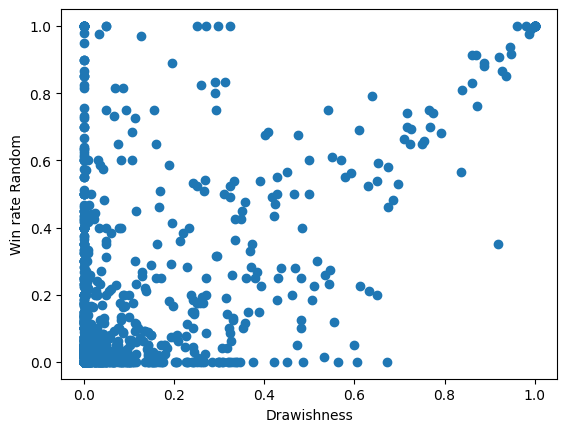

In [28]:
from matplotlib import pyplot as plt

plt.scatter(weightsData["Drawishness"], weightsData["Win rate Random"])
plt.xlabel("Drawishness")
plt.ylabel("Win rate Random");

In [29]:
# Create training data

# Four separate .csv files:
# 1. Agents listed as features, win rate of Agent 1 as label
# 2. Agents listed as features, most common outcome (Win/Draw/Loss) for Agent 1 as label
# 3. Components listed as features, win rate of Agent 1 as label
# 4. Components listed as features, most common outcome (Win/Draw/Loss) for Agent 1 as label

# File #1:

# Instance format:
# - features: agent1, agent2, concept values
# - label: win rate of agent1

trainingAgentsRegression = []
trainingWeights = []

for rulesetId in data["Id"].unique():
    if rulesetId not in weightsData.index:
        print(f"Not adding ruleset #{rulesetId} to training data due to no Random play")
        continue
    
    # Limit data to matches with rulesetId only
    rulesetData = data[data["Id"] == rulesetId]
    
    # Extract concept values
    conceptValues = list(rulesetData[rulesetData.columns[6:]].iloc[0])
    
    # Get match-ups in rulesetId
    rulesetMatchups = rulesetData[["agent1", "agent2"]].drop_duplicates()
    
    for i in range(rulesetMatchups.shape[0]):
        # Limit data to matches from match-up
        rulesetMatchupData = rulesetData[(rulesetData["agent1"] == rulesetMatchups.iloc[i]["agent1"]) & (rulesetData["agent2"] == rulesetMatchups.iloc[i]["agent2"])]
        
        # Compute win rate of Agent 1 (label)
        noWinsByAgent1 = (rulesetMatchupData["utility_agent1"] == 1).sum()
        noDrawsByAgent1 = (rulesetMatchupData["utility_agent1"] == 0).sum()
        
        winRateAgent1 = (noWinsByAgent1 + .5 * noDrawsByAgent1) / rulesetMatchupData.shape[0]
        
        # Add training instance (agents, concept values, win rate of agent1)
        trainingInstance = list(rulesetMatchups.iloc[i]) + conceptValues + [winRateAgent1]
        trainingAgentsRegression.append(trainingInstance)
        trainingWeights.append(weightsData.loc[rulesetId]["Weight"])

trainingAgentsRegression = pd.DataFrame(trainingAgentsRegression, columns=[["Agent 1", "Agent 2"] + list(data.columns[6:]) + ["Win rate of Agent 1"]])
trainingAgentsRegression[["Agent 1", "Agent 2"]] = trainingAgentsRegression[["Agent 1", "Agent 2"]].astype("string")
trainingAgentsRegression

Not adding ruleset #732 to training data due to no Random play
Not adding ruleset #730 to training data due to no Random play
Not adding ruleset #149 to training data due to no Random play
Not adding ruleset #1115 to training data due to no Random play
Not adding ruleset #726 to training data due to no Random play
Not adding ruleset #1047 to training data due to no Random play
Not adding ruleset #734 to training data due to no Random play
Not adding ruleset #1252 to training data due to no Random play
Not adding ruleset #251 to training data due to no Random play
Not adding ruleset #1654 to training data due to no Random play
Not adding ruleset #1050 to training data due to no Random play
Not adding ruleset #1657 to training data due to no Random play


,Agent 1,Agent 2,Stochastic,HiddenInformation,AsymmetricPiecesType,SquareShape,HexShape,TriangleShape,DiamondShape,RectangleShape,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Win rate of Agent 1
0,MCTS-UCB1-0.6-NST,Random,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.00
1,Random,MCTS-UCB1-0.6-NST,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.80
2,Random,MCTS-UCB1-0.6-Random4,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.10
3,MCTS-UCB1-0.6-Random4,Random,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.00
4,Random,MCTS-UCB1GRAVE-0.6-Random4,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,MCTS-UCB1-0.6-NST,Random,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1.00
17878,MCTS-UCB1-0.6-MAST,MCTS-UCB1-0.6-Random4,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1.00
17879,MCTS-UCB1-0.6-Random4,MCTS-UCB1-0.6-MAST,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1.00
17880,Random,MCTS-UCB1GRAVE-0.6-Random0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.05


In [30]:
# File #2:

# Instance format:
# - features: agent1, agent2, concept values
# - label: most common outcome (Win/Draw/Loss) for Agent 1


def translate_win_rate(winRate):
    if winRate > .5:
        return "Win"
    
    if winRate < .5:
        return "Loss"
    
    return "Draw"


trainingAgentsClassification = trainingAgentsRegression.copy()

# Translate win rate of Agent 1 to most common outcome for Agent 1
trainingAgentsClassification["Most common outcome for Agent 1"] = trainingAgentsClassification["Win rate of Agent 1"].apply(lambda winRate: translate_win_rate(winRate.iloc[0]), axis=1).astype("string")
trainingAgentsClassification = trainingAgentsClassification.drop(columns=["Win rate of Agent 1"], level=0)
trainingAgentsClassification

,Agent 1,Agent 2,Stochastic,HiddenInformation,AsymmetricPiecesType,SquareShape,HexShape,TriangleShape,DiamondShape,RectangleShape,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Most common outcome for Agent 1
0,MCTS-UCB1-0.6-NST,Random,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
1,Random,MCTS-UCB1-0.6-NST,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
2,Random,MCTS-UCB1-0.6-Random4,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Loss
3,MCTS-UCB1-0.6-Random4,Random,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Win
4,Random,MCTS-UCB1GRAVE-0.6-Random4,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,MCTS-UCB1-0.6-NST,Random,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Win
17878,MCTS-UCB1-0.6-MAST,MCTS-UCB1-0.6-Random4,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Win
17879,MCTS-UCB1-0.6-Random4,MCTS-UCB1-0.6-MAST,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Win
17880,Random,MCTS-UCB1GRAVE-0.6-Random0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,Loss


In [31]:
# File #3:

# Instance format:
# - features: selection1, selection2, exploration1, exploration2, playout1, playout2, concept values
# - label: win rate of agent1


def split_agent_into_components(col):
    selection = []
    exploration = []
    playout = []
    
    for i in range(col.shape[0]):
        agent = col.iloc[i].iloc[0]
        
        if agent == "Random":
            selection.append("Random")
            exploration.append("1.41421356237")
            playout.append("Random")
        else:
            # Agent is MCTS-based
            components = agent.split("-")
            
            selection.append(components[1])
            exploration.append(components[2])
            playout.append(components[3])
    
    selection = pd.Series(selection).astype("string")
    exploration = pd.Series(exploration).astype("float")
    playout = pd.Series(playout).astype("string")
    
    return selection, exploration, playout


trainingComponentsRegression = trainingAgentsRegression.copy()

# Split agents into their three components
trainingComponentsRegression["Selection 1"], trainingComponentsRegression["Exploration 1"], trainingComponentsRegression["Play-out 1"] = split_agent_into_components(trainingComponentsRegression["Agent 1"])
trainingComponentsRegression["Selection 2"], trainingComponentsRegression["Exploration 2"], trainingComponentsRegression["Play-out 2"] = split_agent_into_components(trainingComponentsRegression["Agent 2"])

# Pull components to the front of the DataFrame; remove variables "Agent 1" and "Agent 2"
trainingComponentsRegression = trainingComponentsRegression[list(trainingComponentsRegression.columns[-6:]) + list(trainingComponentsRegression.columns[2:-6])]
trainingComponentsRegression

,Selection 1,Exploration 1,Play-out 1,Selection 2,Exploration 2,Play-out 2,Stochastic,HiddenInformation,AsymmetricPiecesType,SquareShape,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Win rate of Agent 1
0,UCB1,0.600000,NST,Random,1.414214,Random,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1.00
1,Random,1.414214,Random,UCB1,0.600000,NST,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.80
2,Random,1.414214,Random,UCB1,0.600000,Random4,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.10
3,UCB1,0.600000,Random4,Random,1.414214,Random,False,False,True,False,...,False,False,False,False,False,False,False,False,False,1.00
4,Random,1.414214,Random,UCB1GRAVE,0.600000,Random4,False,False,True,False,...,False,False,False,False,False,False,False,False,False,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,UCB1,0.600000,NST,Random,1.414214,Random,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1.00
17878,UCB1,0.600000,MAST,UCB1,0.600000,Random4,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1.00
17879,UCB1,0.600000,Random4,UCB1,0.600000,MAST,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1.00
17880,Random,1.414214,Random,UCB1GRAVE,0.600000,Random0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,0.05


In [32]:
# File #4:

# Instance format:
# - features: selection1, selection2, exploration1, exploration2, playout1, playout2, concept values
# - label: most common outcome (Win/Draw/Loss) for Agent 1

trainingComponentsClassification = trainingComponentsRegression.copy()

# Translate win rate of Agent 1 to most common outcome for Agent 1
trainingComponentsClassification["Most common outcome for Agent 1"] = trainingComponentsClassification["Win rate of Agent 1"].apply(lambda winRate: translate_win_rate(winRate.iloc[0]), axis=1).astype("string")
trainingComponentsClassification = trainingComponentsClassification.drop(columns=["Win rate of Agent 1"], level=0)
trainingComponentsClassification

,Selection 1,Exploration 1,Play-out 1,Selection 2,Exploration 2,Play-out 2,Stochastic,HiddenInformation,AsymmetricPiecesType,SquareShape,...,CrossBoard,KintsBoard,PachisiBoard,FortyStonesWithFourGapsBoard,DiceD2,DiceD4,DiceD6,PlayersWithDirections,IsPieceAt,Most common outcome for Agent 1
0,UCB1,0.600000,NST,Random,1.414214,Random,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Win
1,Random,1.414214,Random,UCB1,0.600000,NST,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Win
2,Random,1.414214,Random,UCB1,0.600000,Random4,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Loss
3,UCB1,0.600000,Random4,Random,1.414214,Random,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Win
4,Random,1.414214,Random,UCB1GRAVE,0.600000,Random4,False,False,True,False,...,False,False,False,False,False,False,False,False,False,Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17877,UCB1,0.600000,NST,Random,1.414214,Random,False,False,False,True,...,False,False,False,False,False,False,False,True,False,Win
17878,UCB1,0.600000,MAST,UCB1,0.600000,Random4,False,False,False,True,...,False,False,False,False,False,False,False,True,False,Win
17879,UCB1,0.600000,Random4,UCB1,0.600000,MAST,False,False,False,True,...,False,False,False,False,False,False,False,True,False,Win
17880,Random,1.414214,Random,UCB1GRAVE,0.600000,Random0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,Loss


In [33]:
# Turn string variables into categorical ones

variablesToConvert = ["Agent 1", "Agent 2", "Selection 1", "Selection 2", "Play-out 1", "Play-out 2", "Most common outcome for Agent 1"]

for df in [trainingAgentsRegression, trainingAgentsClassification, trainingComponentsRegression, trainingComponentsClassification]:
    for var in variablesToConvert:
        if var in df.columns:
            df[var] = df[var].astype("category")

In [34]:
# Export to .csv files

trainingAgentsRegression.to_csv(
    "../training_data/sets/agents regression.csv",
    index=False
)
trainingAgentsClassification.to_csv(
    "../training_data/sets/agents classification.csv",
    index=False
)
trainingComponentsRegression.to_csv(
    "../training_data/sets/components regression.csv",
    index=False
)
trainingComponentsClassification.to_csv(
    "../training_data/sets/components classification.csv",
    index=False
)

pd.Series(trainingWeights).to_csv(
    "../training_data/weights.csv",
    index=False
)